# HW7_ml6506

# Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import urllib.request
from urllib.request import urlretrieve as urlretrieve
import geopandas as gpd
import os
import json
import requests
import zipfile
import io
from io import StringIO
from fiona.crs import from_epsg
import shapely
from shapely.geometry import Point, LineString
import matplotlib.pylab as plt
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False

## 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [2]:
urllib.request.urlretrieve( "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile", "pumadata.zip")

('pumadata.zip', <http.client.HTTPMessage at 0x7f0c60957fd0>)

In [3]:
!mv pumadata.zip $PUIDATA

In [4]:
# unzip the zipped folder
import zipfile
zip_ref = zipfile.ZipFile( os.getenv("PUIDATA") + "/" +"pumadata.zip", 'r')
zip_ref.extractall( os.getenv("PUIDATA") )
zip_ref.close()

In [5]:
ls $PUIDATA

201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.csv.zip
201601-citibike-tripdata.zip
201602-citibike-tripdata.csv
201602-citibike-tripdata.zip
201801JC-201801-citibike-tripdata.csv.zip
ACS_16_1YR_GCT2801.ST50_metadata.csv
ACS_16_1YR_GCT2801.ST50.txt
ACS_16_1YR_GCT2801.ST50_with_ann.csv
ACS_16_1YR_GCT2801.ST50.zip
aff_download_readme_ann.txt
dshstreet.csv
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.dbf
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.prj
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.shp
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.shx
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.dbf
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.prj
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.shp
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.shx
geo_export_c9db4743-c1d8-4258-ac3f-5de786609898.dbf
geo_export_c9db4743-c1d8-4258-ac3f-5de786609898.prj
geo_export_c9db4743-c1d8-4258-ac3f-5de786609898.shp
geo_exp

In [6]:
from geopandas import GeoDataFrame
shape_path="PUIdata/geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.shp"
pumashp = GeoDataFrame.from_file(shape_path)

In [7]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [8]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2 plot the PUMA NYC regions

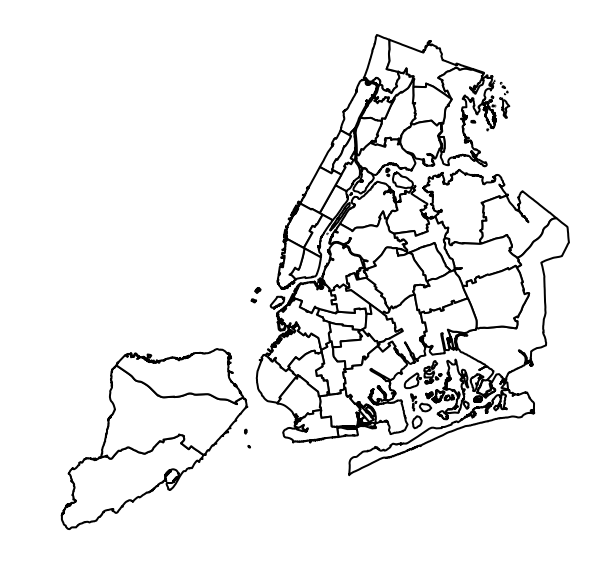

In [9]:
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);


# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API:

In [10]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI

In [11]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [12]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

You need two features: total number of households, and number of households with broadband access

Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations (rows that start with "B28002") that include the word "Broadband" in the description.

The syntax is a lost comprehension:

    as = \[a for a in listOfAs\] 

is simply a compact way to write

    as = \[\]
    for a in listOfAs:
        as.append(a)

with an if statement tha selects broadband

In [13]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL')]


chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the _001 variable (B28002_001 in this case). "E" stands for estimate. M stands for margin of error, EA estimate annotations, MA margin of error annotations. You want the estimate for this exercise.

In [14]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [15]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

Now that you have the variable names use them to extract the relevant data with the ACS API.

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=[variable Name],NAME

geometry: for=[geometry]:[desired geometry values]in=[larger geometry]:[desired larger geometry values]

API key: key:[api key]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":*" means all PUMAS

state:36 is New York State

In [16]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" 
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" 
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head(1)

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN


In [18]:
pumaPP.shape

(145, 5)

In [19]:
# the total number of households
len(pumaPP.index)

145

In [20]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [21]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [22]:
pumaBB = pumaBB.merge(pumaPP, left_on='NAME', right_on='NAME',how='inner')
pumaBB['pcBB'] = pumaBB['B28002_004E']/pumaPP['B28002_001E']*100
pumaBB.drop(['state_x','Unnamed: 4_x', 'state_y','public use microdata area_y','Unnamed: 4_y'],axis=1,inplace=True)

In [23]:
pumaBB.rename(columns={'public use microdata area_x':'public use microdata area'},inplace=True)
pumaBB.head()

,B28002_004E,NAME,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all

- Topics: Product Type -> Geography Comparison Table 

select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.

Your table shold be labeled as: GCT2801

One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste! Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following sftp command

 fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu

Input your password

 Password: 
 Connected to staging.cusp.nyu.edu.

This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)

 sftp> cd /home/fbianco/PUIdata             
Use the sftp command put to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)

 sftp> put /Users/fbianco/Downloads/aff_download.zip
You should see:

        Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need.

In [24]:
# unzip the zipped folder
import zipfile
zip_ref = zipfile.ZipFile( os.getenv("PUIDATA") + "/" +"ACS_16_1YR_GCT2801.ST50.zip", 'r')
zip_ref.extractall(os.getenv("PUIDATA") )
zip_ref.close()

In [25]:
ls $PUIDATA

201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.csv.zip
201601-citibike-tripdata.zip
201602-citibike-tripdata.csv
201602-citibike-tripdata.zip
201801JC-201801-citibike-tripdata.csv.zip
ACS_16_1YR_GCT2801.ST50_metadata.csv
ACS_16_1YR_GCT2801.ST50.txt
ACS_16_1YR_GCT2801.ST50_with_ann.csv
ACS_16_1YR_GCT2801.ST50.zip
aff_download_readme_ann.txt
dshstreet.csv
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.dbf
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.prj
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.shp
geo_export_3e5af34b-74f8-4668-9a0f-147a0f1ea9f5.shx
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.dbf
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.prj
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.shp
geo_export_4ebc134f-6495-4e4e-8220-6844796768a3.shx
geo_export_c9db4743-c1d8-4258-ac3f-5de786609898.dbf
geo_export_c9db4743-c1d8-4258-ac3f-5de786609898.prj
geo_export_c9db4743-c1d8-4258-ac3f-5de786609898.shp
geo_exp

In [26]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.drop(0, inplace=True)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


notice 2 things:

- that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
- that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.

In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id

## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [27]:
pumaBB.head()

,B28002_004E,NAME,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,402,61146,78.150656


In [28]:
#rename column 
bbpc.index.astype(int)
bbpc = bbpc.rename(columns={'GCT_STUB.target-geo-id2':'gid'})
bbpc.head()

,gid,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [29]:
bbpc["gid"] = bbpc.gid.astype(int) - 3600000
bbpc.head()

,gid,HC01,HC02
1,-3599999,74.7,0.5
2,-3499900,70.9,2.5
3,-3499800,80.5,2.7
4,-3499699,87.0,2.8
5,-3499698,81.9,2.9


In [30]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [31]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [32]:
pumashp['puma'] = pumashp['puma'].astype(int)
pumaBB['public use microdata area'] = pumaBB['public use microdata area'].astype(int)

In [33]:
#choropleth of the percentage of internet axcess
#,left_on='puma',right_on='public use microdata area'
pumashp_1 = pd.merge(pumashp, pumaBB, left_on='puma',right_on='public use microdata area', how='outer')
pumashp_2 = pumashp_1.dropna(how='any',axis=0)
pumashp_2.head()

# cp.choroplethNYC(...)

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,public use microdata area,B28002_001E,pcBB
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618


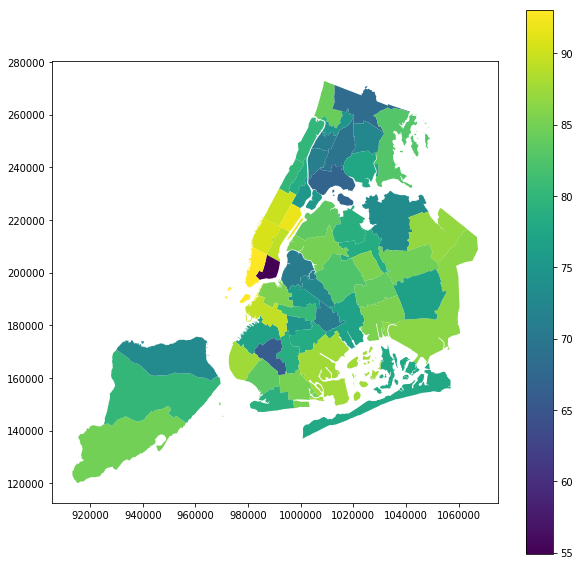

In [34]:
#fig = plt.plot(figsize=(10,10))
pumashp_2.to_crs(epsg=2263).plot(column='pcBB',legend=True, figsize=(10,10))

#  4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe read it in from the HW7_fb55 folder in : https://github.com/fedhere/PUI2018_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

acquire the linkNYC locations and prepare them into a dataframe read it in from the HW7_fb55 folder in : https://github.com/fedhere/PUI2018_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [35]:
linkNYC = pd.read_csv('linkNYClocations.csv')
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [36]:
linkNYC.shape

(1414, 5)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab

In [37]:
geometry = [Point (xy) for xy in zip(linkNYC.longitude, linkNYC.latitude)]
linkNYC = linkNYC.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
linkNYC = GeoDataFrame(linkNYC, crs=crs, geometry=geometry)
# linkNYC.shape

In [38]:
linkNYC.head()

,Unnamed: 0,link_site,date_link_,geometry
0,0,bk-01-138951,2017-07-01,POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,2017-07-01,POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,2017-07-01,POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,2017-04-28,POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,2017-03-31,POINT (-73.953439 40.728133)


In [39]:
linkNYC = gpd.GeoDataFrame(linkNYC)

In [40]:
linkNYC.crs = from_epsg(code=4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

## plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

I have also color coded the station by how long ago they have been installed, using the date datetime variable

In [41]:
pumashp_2.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,public use microdata area,B28002_001E,pcBB
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618


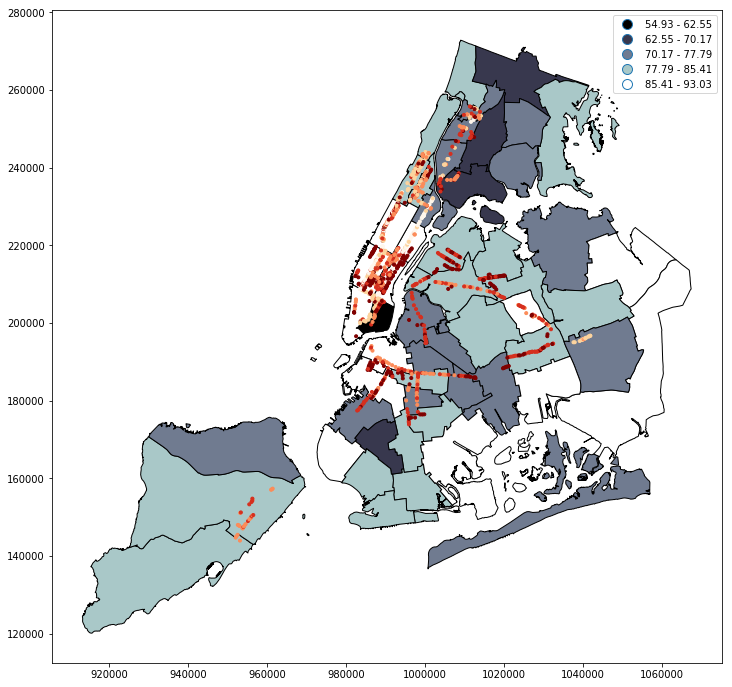

In [42]:

fig,ax = plt.subplots(figsize=(12,12))

pumashp_2.to_crs(epsg=2263).plot(ax=ax,column='pcBB', edgecolor='black',cmap='bone',legend=True, scheme='Equal_interval',figsize=(10,10))
linkNYC.to_crs(epsg=2263).plot(ax=ax,column='date_link_',marker=".",cmap='OrRd',figsize=(10,10),scheme='Equal_interval')

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by variable is B00001_001E, and of course your geometry is PUMA, public%20use%20microdata%20area:*, as before

In [43]:
pumashp_2.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,public use microdata area,B28002_001E,pcBB
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618


In [44]:
# getting the total population by puma
keypop = 'B00001_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keypop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" 
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPop.rename(columns={'B00001_001E':'population'},inplace=True)
pumaPop.head()

,population,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [45]:
linkpp = pumashp_2.merge(pumaPop, left_on='public use microdata area',right_on='public use microdata area')
linkpp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,public use microdata area,B28002_001E,pcBB,population,NAME_y,state,Unnamed: 4
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN


## 5.2 find the number of station per 100 people per PUMA

Important you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are not "flat coordinates". Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )

(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

convert coordinates for pumashp and linkNYC

create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [46]:
linkpp = linkpp.to_crs(epsg=2263)
linkNYC = linkNYC.to_crs(epsg=2263)
linkNYC['count'] = 1
linkpp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,public use microdata area,B28002_001E,pcBB,population,NAME_y,state,Unnamed: 4
0,3701.0,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN
4,4015.0,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN


In [47]:

linkpp = gpd.sjoin(linkpp,linkNYC,how="inner", op='intersects')
linkpp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,public use microdata area,B28002_001E,pcBB,population,NAME_y,state,Unnamed: 4,index_right,Unnamed: 0,link_site,date_link_,count
0,3701.0,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,1286,1286,bx-08-145850,2017-06-10,1
4,4015.0,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,1218,1218,bk-14-145758,2017-03-03,1
4,4015.0,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,1216,1216,bk-14-145789,2017-03-06,1
4,4015.0,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,1215,1215,bk-14-145814,2017-04-08,1
6,3705.0,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",3705,58706,69.425612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,927,927,bx-06-118922,2017-10-20,1


In [48]:
count_linkNYC = linkpp['count'].groupby(linkpp['public use microdata area']).sum()
count_linkNYCf = count_linkNYC.to_frame()
count_linkNYCf['puma'] = count_linkNYCf.index
count_linkNYCf.rename(columns={'count':'total_amount'},inplace=True)
count_linkNYCf.head()

,total_amount,puma
public use microdata area,,
3701,1,3701
3705,1,3705
3706,20,3706
3707,29,3707
3708,19,3708


In [49]:
pumashplc = pumashp_2.merge(pumaPop, left_on='public use microdata area',right_on='public use microdata area',how='inner')
pumashplc = pumashplc.merge(count_linkNYCf,left_on='public use microdata area',right_on=count_linkNYCf['puma'],how='outer')
pumashplc.head()

,puma_x,shape_area,shape_leng,geometry,B28002_004E,NAME_x,public use microdata area,B28002_001E,pcBB,population,NAME_y,state,Unnamed: 4,total_amount,puma_y
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,1.0,3701.0
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,NaN,NaN
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,NaN,NaN
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,NaN,NaN
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,3.0,4015.0


finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have all the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [50]:
#linkNYC per 100 inhabitants
pumashplc['linkNYCp100p'] = pumashplc['total_amount']/pumashplc['population']*100
pumashplc["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

In [51]:
pumashplc = pumashplc.fillna(0)
pumashplc.head()

,puma_x,shape_area,shape_leng,geometry,B28002_004E,NAME_x,public use microdata area,B28002_001E,pcBB,population,NAME_y,state,Unnamed: 4,total_amount,puma_y,linkNYCp100p
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,0.0,1.0,3701.0,0.065920
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,0.0,0.0,0.0,0.000000
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,0.0,0.0,0.0,0.000000
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,0.0,0.0,0.0,0.000000
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,0.0,3.0,4015.0,0.119284


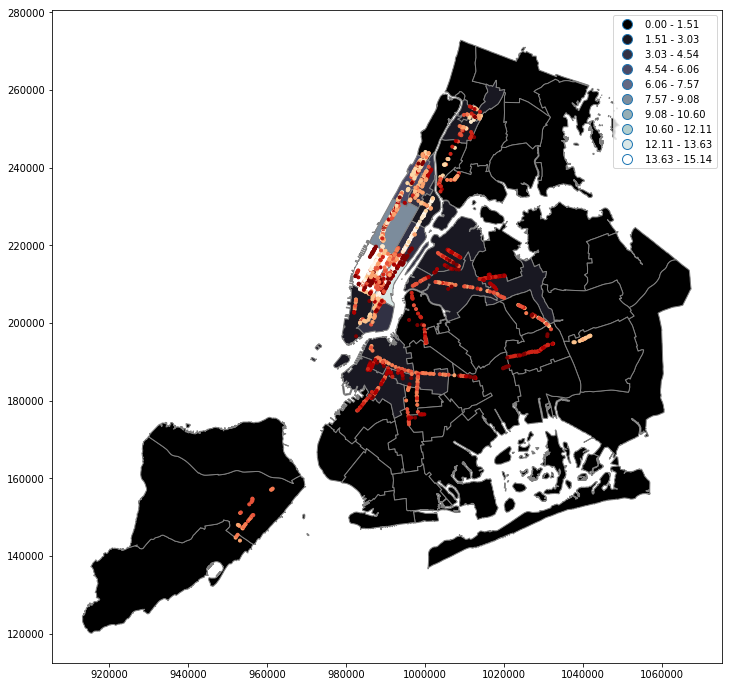

In [52]:
fig,ax = plt.subplots(figsize=(12,12))

pumashplc.to_crs(epsg=2263).plot(ax=ax,column='linkNYCp100p', edgecolor='grey',cmap='bone',legend=True, scheme='Equal_interval',k=10)
linkNYC.to_crs(epsg=2263).plot(ax=ax,column='date_link_',marker=".",cmap='OrRd',scheme='Equal_interval',k=10)